# Image Classification Model From Scratch Using PyTorch

- [Source](https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212)

### Image Recognition


### Tensors
- Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

- Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other specialized hardware to accelerate computing.

### Torch.Autograd

**torch.autograd** is PyTorch’s automatic differentiation engine that powers neural network training
[Source](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

- Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters (consisting of weights and biases), which in PyTorch are stored in tensors.

Training a NN happens in two steps:

- **Forward Propagation:** In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

- **Backward Propagation:** In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent.

### Steps to build an Image Classification Model



In [1]:
# Import Libraries

import matplotlib.pyplot as plt 
import numpy as np #For transformation

import torch # PyTorch package
import torchvision #Load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural networks
import torch.nn.functional as F #import convolution functions like Relu
import torch.optim as optim #optimzer

### 1. Load and normalize data

In [2]:
# python image library of range [0, 1] 
# transform them to tensors of normalized range[-1, 1]

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


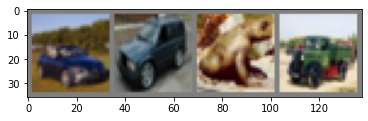

car car frog truck


In [3]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

### 2. Define the CNN
![CNN](https://miro.medium.com/max/2000/1*c2ubkAfmplp3r7hTz-mk5A.png "CNN Model")

In [4]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
	
    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3.Define a Loss function and optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [6]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

TypeError: object.__new__() takes exactly one argument (the type to instantiate)

### 5. Test the network on test data


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
#TEsting on 10k imgs

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))